# Анализ рекламных затрат развлекательного приложения Procrastinate Pro+

Необходимо проанализировать, почему компания терпит убытки последние несколько месяцев несмотря на большие вложения в рекламу.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы



Цель - изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

План работы:
1. Загрузить данные и подготовь их к анализу
2. Задать функции для расчёта и анализа LTV, ROI, удержания и конверсии
3. Провести исследовательский анализ данных
4. Провести анализ маркетинга
5. Оцените окупаемость рекламы
6. Написать выводы

## Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

### Подключим библиотеки и загрузим данные

In [1]:
# подключим библиотеки
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# загрузим данные
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')
events = None  # других событий нет, None — чтобы не «сломать» get_profiles()

### Проведем предобработку данных датафрейма с посещениями

In [3]:
#создадим функцию для вывода данных о таблице
def preproc(df, col=[]):
    print('\033[1m' + 'Информация о таблице:' + '\033[0m')
    print(df.info())
    print('\033[1m' + 'Количество дубликатов в таблице:' + '\033[0m', df.duplicated().sum())
    print('\033[1m' + 'Количество пропусков в таблице:' + '\033[0m')
    print(df.isna().sum())
    print('\033[1m' + 'Первые 5 строк таблицы:' + '\033[0m')
    print(df.head())
    return 

#применим функцию к таблице посещений
preproc(visits)    

Информация о таблице:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 309901 entries, 0 to 309900
,Data columns (total 6 columns):
, #   Column         Non-Null Count   Dtype 
,---  ------         --------------   ----- 
, 0   User Id        309901 non-null  int64 
, 1   Region         309901 non-null  object
, 2   Device         309901 non-null  object
, 3   Channel        309901 non-null  object
, 4   Session Start  309901 non-null  object
, 5   Session End    309901 non-null  object
,dtypes: int64(1), object(5)
,memory usage: 14.2+ MB
,None
,Количество дубликатов в таблице: 0
,Количество пропусков в таблице:
,User Id          0
,Region           0
,Device           0
,Channel          0
,Session Start    0
,Session End      0
,dtype: int64
,Первые 5 строк таблицы:
,        User Id         Region   Device  Channel        Session Start  \
,0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
,1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31

Ненулевых значений нет. Явных дубликатов нет. Необходимо заменить тип данных в столбцах Session Start и Session End. Приведем названия столбцов в "змеиный" регистр

In [4]:
#переименуем столбцы
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

#изменим тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

#выведем данные о датафрейме для проверки
print(visits.info())

visits.head()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 309901 entries, 0 to 309900
,Data columns (total 6 columns):
, #   Column         Non-Null Count   Dtype         
,---  ------         --------------   -----         
, 0   user_id        309901 non-null  int64         
, 1   region         309901 non-null  object        
, 2   device         309901 non-null  object        
, 3   channel        309901 non-null  object        
, 4   session_start  309901 non-null  datetime64[ns]
, 5   session_end    309901 non-null  datetime64[ns]
,dtypes: datetime64[ns](2), int64(1), object(3)
,memory usage: 14.2+ MB
,None


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


### Проведем предобработку данных датафрейма с заказами

In [5]:
#применим функцию к таблице c заказами
preproc(orders)    

Информация о таблице:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 40212 entries, 0 to 40211
,Data columns (total 3 columns):
, #   Column    Non-Null Count  Dtype  
,---  ------    --------------  -----  
, 0   User Id   40212 non-null  int64  
, 1   Event Dt  40212 non-null  object 
, 2   Revenue   40212 non-null  float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 942.6+ KB
,None
,Количество дубликатов в таблице: 0
,Количество пропусков в таблице:
,User Id     0
,Event Dt    0
,Revenue     0
,dtype: int64
,Первые 5 строк таблицы:
,        User Id             Event Dt  Revenue
,0  188246423999  2019-05-01 23:09:52     4.99
,1  174361394180  2019-05-01 12:24:04     4.99
,2  529610067795  2019-05-01 11:34:04     4.99
,3  319939546352  2019-05-01 15:34:40     4.99
,4  366000285810  2019-05-01 13:59:51     4.99


Ненулевых значений нет. Явных дубликатов нет. Необходимо заменить тип данных в столбце Event Dt. Приведем названия столбцов в "змеиный" регистр

In [6]:
#переименуем столбцы
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

#изменим тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

#выведем данные о датафрейме для проверки
print(orders.info())

orders

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 40212 entries, 0 to 40211
,Data columns (total 3 columns):
, #   Column    Non-Null Count  Dtype         
,---  ------    --------------  -----         
, 0   user_id   40212 non-null  int64         
, 1   event_dt  40212 non-null  datetime64[ns]
, 2   revenue   40212 non-null  float64       
,dtypes: datetime64[ns](1), float64(1), int64(1)
,memory usage: 942.6 KB
,None


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


### Проведем предобработку данных датафрейма с расходами

In [7]:
#применим функцию к таблице с расходами
preproc(costs)  

Информация о таблице:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1800 entries, 0 to 1799
,Data columns (total 3 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   dt       1800 non-null   object 
, 1   Channel  1800 non-null   object 
, 2   costs    1800 non-null   float64
,dtypes: float64(1), object(2)
,memory usage: 42.3+ KB
,None
,Количество дубликатов в таблице: 0
,Количество пропусков в таблице:
,dt         0
,Channel    0
,costs      0
,dtype: int64
,Первые 5 строк таблицы:
,           dt   Channel  costs
,0  2019-05-01  FaceBoom  113.3
,1  2019-05-02  FaceBoom   78.1
,2  2019-05-03  FaceBoom   85.8
,3  2019-05-04  FaceBoom  136.4
,4  2019-05-05  FaceBoom  122.1


Ненулевых значений нет. Явных дубликатов нет. Необходимо заменить тип данных в столбце dt. Приведем названия столбцов в "змеиный" регистр

In [8]:
#переименуем столбцы
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#выведем данные о датафрейме для проверки
print(costs.info())

costs.head()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1800 entries, 0 to 1799
,Data columns (total 3 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   dt       1800 non-null   object 
, 1   channel  1800 non-null   object 
, 2   costs    1800 non-null   float64
,dtypes: float64(1), object(2)
,memory usage: 42.3+ KB
,None


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


## Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Зададим функцию для создания профилей пользователей

In [9]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

### Зададим функцию для подсчёта Retention Rate

In [10]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

### Зададим функцию для подсчёта конверсии

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


### Зададим функцию для подсчёта LTV 

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Зададим функцию для сглаживания данных

In [13]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


### Зададим функцию для построения графика Retention Rate

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


### Зададим функцию для построения графика конверсии

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Зададим функцию для визуализации LTV и ROI

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

### Составим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей

In [17]:
profiles = get_profiles(visits, orders, events, costs)

profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()

print('Минимальная дата привлечения пользователей: ', min_analysis_date)
print('Максимальная дата привлечения пользователей: ', max_analysis_date)

Минимальная дата привлечения пользователей:  2019-05-01
,Максимальная дата привлечения пользователей:  2019-10-27


Компаниия привлекала пользователей с 1 мая 2019 года по 27 октября 2019 года. Результаты соответствуют описанию.

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
def group_by_category(df, col):
    result = df.groupby(col).agg({'user_id': 'nunique', 'payer': 'mean'})\
    .sort_values(by='payer', ascending=False).style.format({'payer': '{:.2%}'})
    return result

In [20]:
group_by_category(profiles, 'region')

,user_id,payer
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


Больше всего пользователей привлечено из США - около 100к человек. Пользователей из Германии, Британии и Франции меньше в несколько раз. Наибольшая доля платящих клиентов так же наблюдается в США - 6,9%, далее Германиия - 4,1%, Британия - 4% и Франция 3,8%.

### Определим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [21]:
group_by_category(profiles, 'device')

,user_id,payer
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


Привлеченные пользователи чаще всего используют iPhone - около 54к человек. Реже используют Mac, Android и PC. Однако наибольшая доля платящих клиентов используют в Mac и iPhone - 6,3% и 6,2% соответственно. Доля пользователей использующих Android - 5,9%, а PC - 5%.

### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [22]:
group_by_category(profiles, 'channel')

,user_id,payer
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Больше всего пришло пользователей органически - около 56к. А среди рекламных источников FaceBoom - около 29к  и TipTop - около 20к пользователей. Наибольшая доля платящих клиентов пришла через FaceBoom - 12%, AdNonSense	- 11% и lambdaMediaAds - 10,5%. Наименьшая доля среди клиентов пришедших органически.

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

###  Посчитаем общую сумму расходов на маркетинг.

In [23]:
print('Общая сумма расходов на маркетинг: ', costs['costs'].sum())

Общая сумма расходов на маркетинг:  105497.30000000002


###  Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [24]:
costs_group = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
costs_group['costs_ratio'] = costs_group['costs']/costs_group['costs'].sum()
costs_group.style.format({'costs_ratio': '{:.2%}'})

,costs,costs_ratio
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


###  Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. 

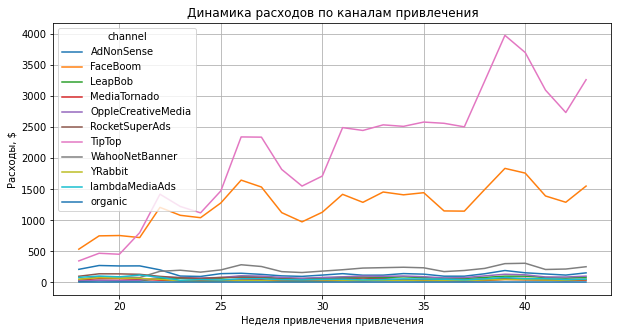

In [25]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week

profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Расходы, $')
plt.xlabel('Неделя привлечения привлечения')
plt.title('Динамика расходов по каналам привлечения')
plt.show()

### Построим график с визуализацией динамики изменения расходов во времени по месяцам по каждому источнику. 

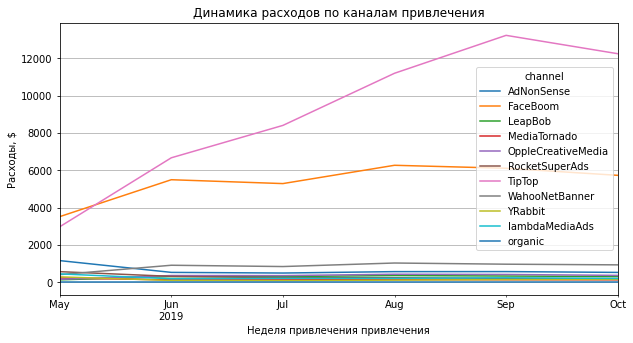

In [26]:
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Расходы, $')
plt.xlabel('Неделя привлечения привлечения')
plt.title('Динамика расходов по каналам привлечения')
plt.show()

### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [27]:
profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Выводы: 
Больше всего бюджета тратили на рекламный источник TipTop  и FaceBoom. Расходы на рекламу за прошедшие полгода для большиства каналов привлечения не изменилась. Значительно увеличились затраты на рекламу по каналу TipTop.

## Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [28]:
#исключим органических пользователей
profiles = profiles.query('channel != "organic"')

#проверим, что все органические пользователи исключены
profiles.loc[profiles['channel'] == 'organic', 'channel'].count()

0

In [29]:
#зададим горизонт анализа
horizon_days = 14

#зададим момент анализа
observation_date = datetime(2019, 11, 1).date()

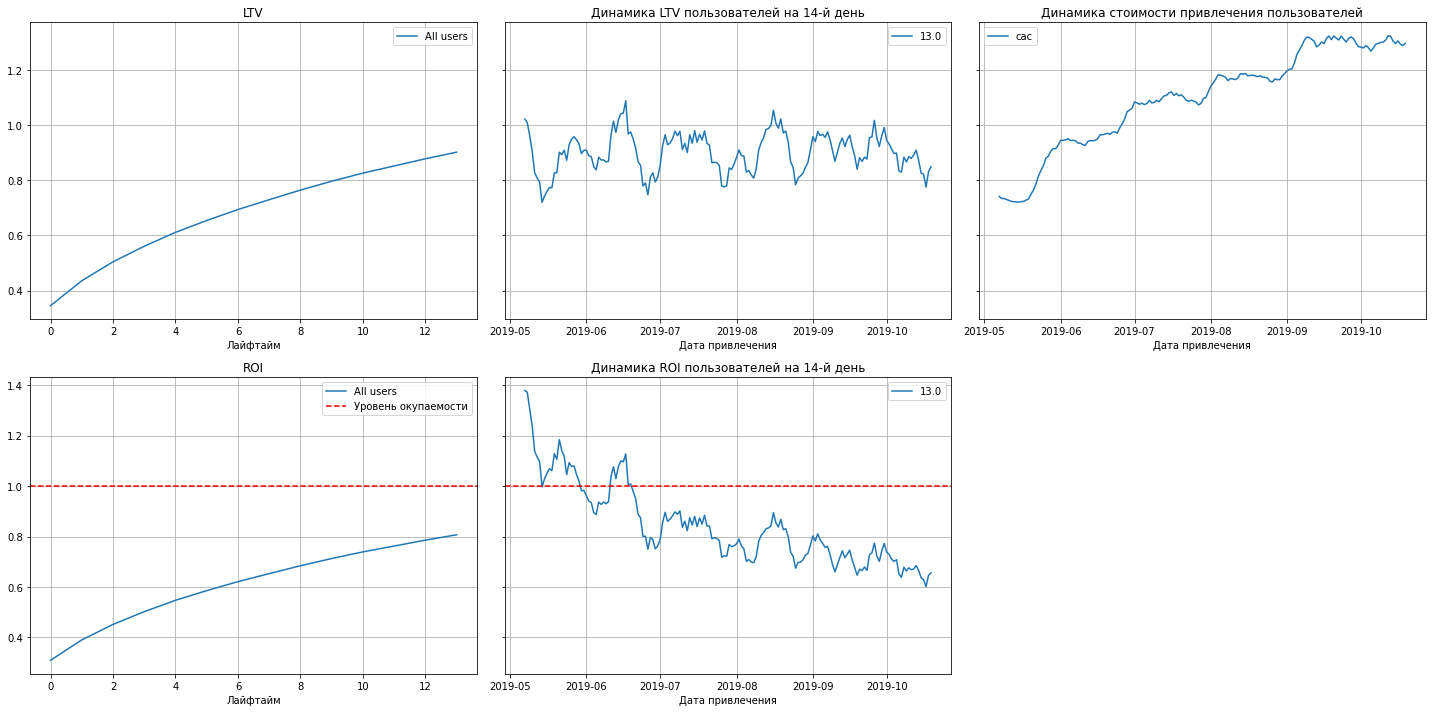

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 7)

- LTV на момент анализа составляет 0,8 на 14 день.
- LTV клиента на протяжении полугода колеблется в диапазоне от 0,8 до 1. Наблюдается боковой тренд. Это свидетельствует о том, что качественно продукт для покупателей не изменился.
- Динамика изминения САС показывает, что стоимость привлечение клиента постоянно растет. Наибольший рост был в середине мая. Это связано с изменение затрат на рекламу.
- ROI составляет 0,8 на 14 день, что свидетельствует о том, что реклама не окупается. 
- Динамика изменения ROI показывает, что реклама окупала себя до конца мая. Позже был всплеск окупаемости выше 1 в середине июня. С середины июня реклама себя не окупает. Сохраняется нисходящий тренд. Это связано с тем, что LTV не меняется, а CAC падает.

### Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии. 

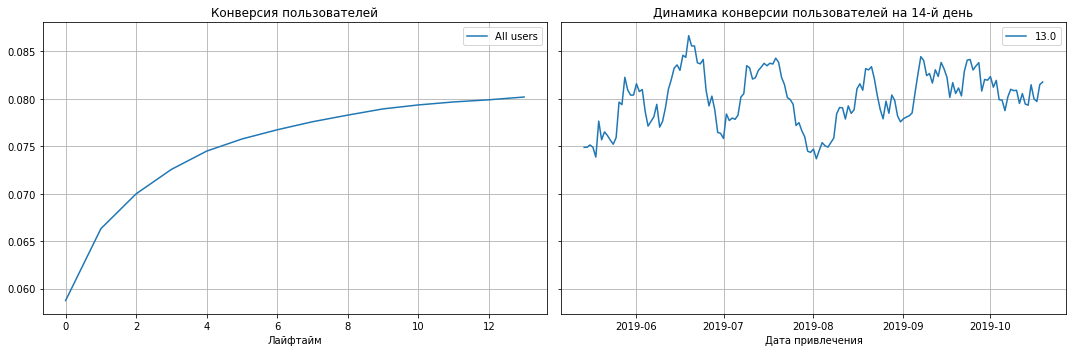

In [31]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion, conversion_history, horizon_days, 14)

- Конверсия растет - значит ошибок в расчетах нет. Конверсия на момент анализа составляет 8% на 14 день.
- Динамика конверсии колеблется возле значения в 8% +-0,5%, показывая боковой тренд. Это означает, что в целом качество рекламных объявлений не изменилось.

### Проверим удержание пользователей и динамику его изменения. Построим и изучим графики удержания. 

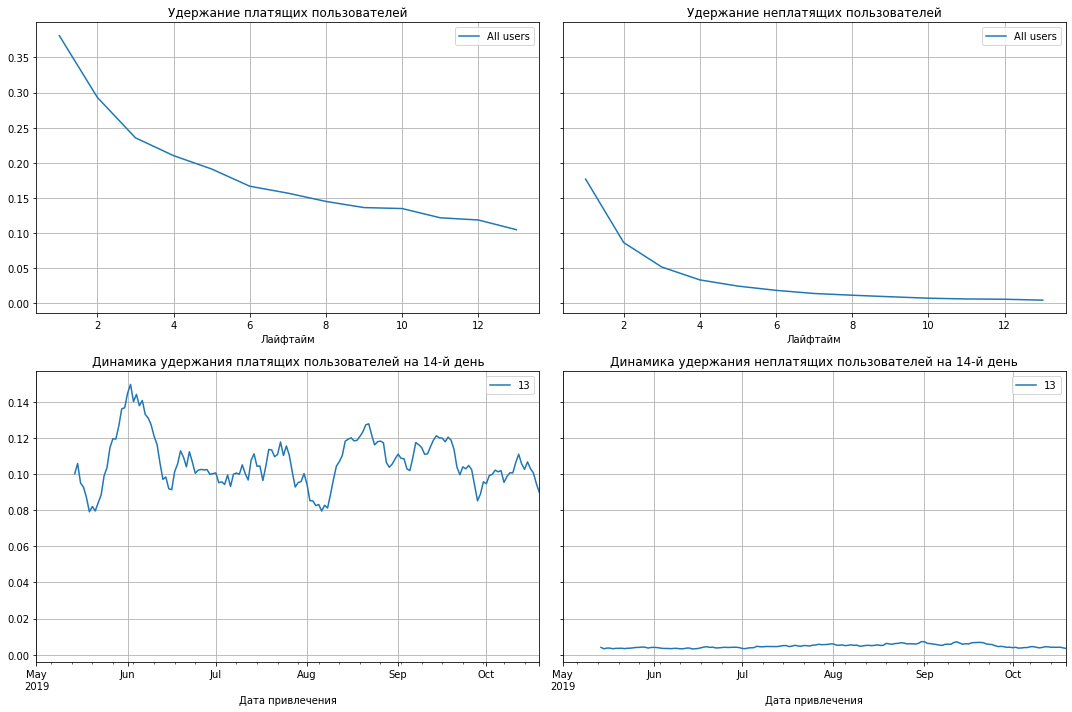

In [32]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)


plot_retention(retention, retention_history, horizon_days, 14)

- Удержание платящих пользователей выше, чем удержание неплатящих, как и должно быть, значит расчеты верны.
- Удержание пользователей показывают плавное нисходящие движение, как и должно быть, значит расчеты верны.
- Наибольшее удержания платящих пользователей наблюдается в начале июня - 14,5%, наименьшее удержание в середине мая и начале августа - 8%.
- Удержание неплатящих пользователей почти не меняется во времени и составляет около 0,5%.


### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

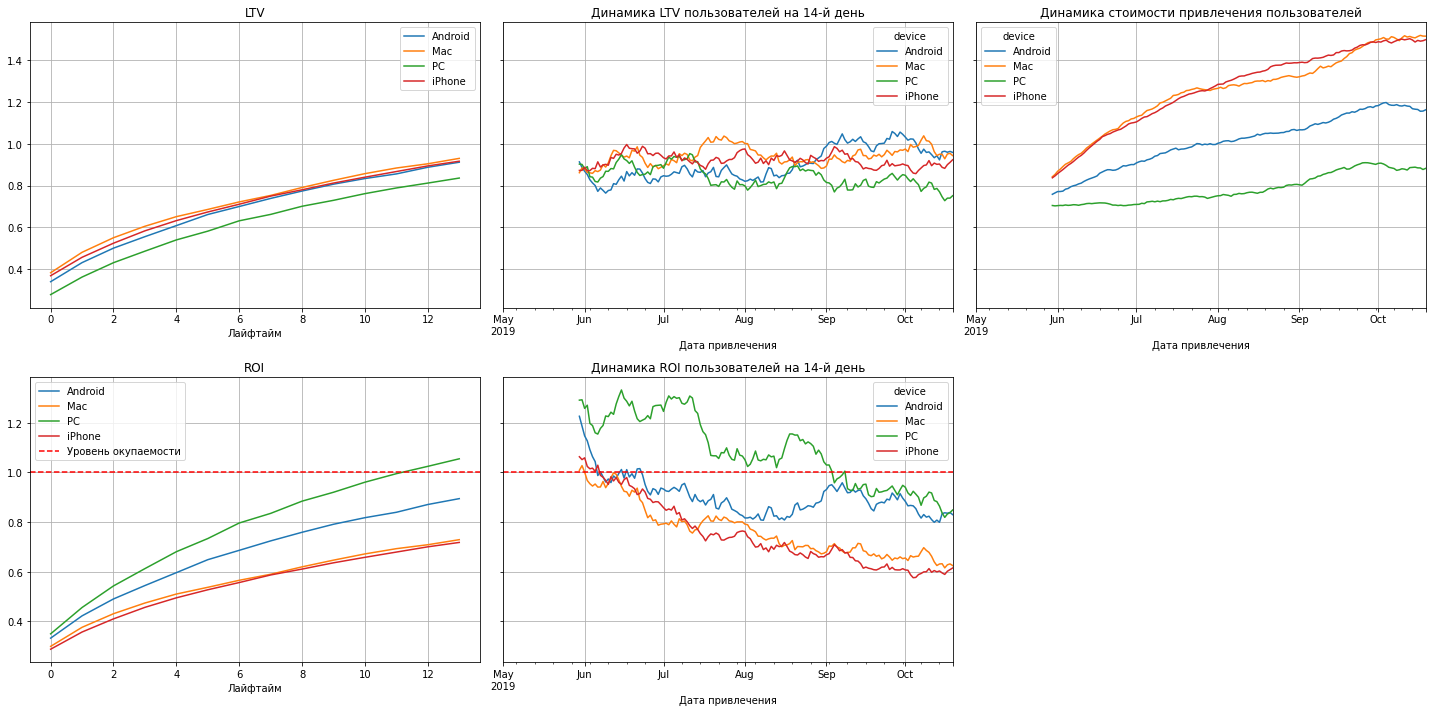

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['device'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 30)

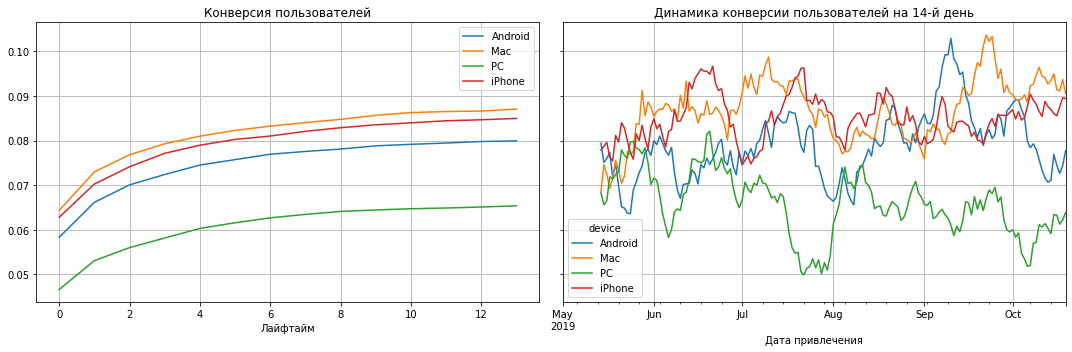

In [34]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, ['device'])

plot_conversion(conversion, conversion_history, horizon_days, 14)

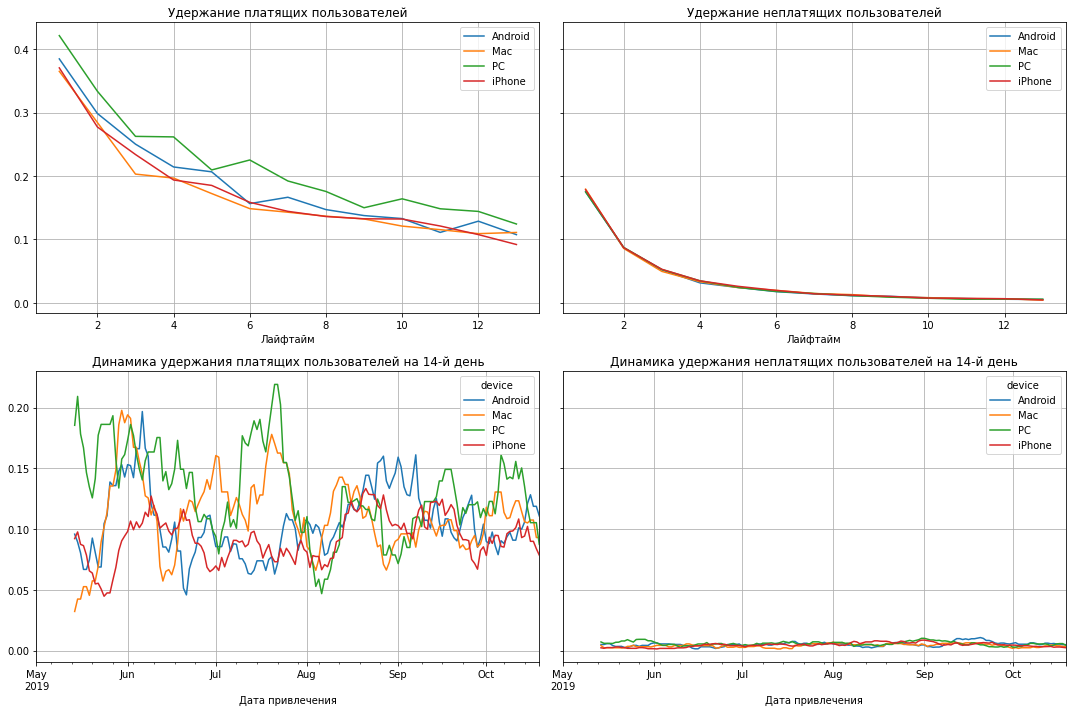

In [35]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['device'])


plot_retention(retention, retention_history, horizon_days, 14)

- LTV пользователей с устройством PC ниже, чем у пользователейс другими устройствами.
- Динамика LTV пользователей с устройством Android за последние погода показывает восходящий тренд. Пользователи с другими устройствами - боковой тренд.
- Динамика САС увеличивается по всем устройствам. По PC меньше всего, Mac и iPhone больше всего. Скачков роста САС не наблюдается.
- Реклама окупается по пользователям с устройтвом PC на 12 день. ROI на 14 день PC - 105%, Android - 90%, Mac и iPhone - 70%. В первую очередь необходимо обратить внимание именно на пользователей Mac и iPhone, а после Android.
- Согласно графику динамики ROI окупаемость пользователей с Mac и iPhone показывает нисходящий тренд без скачков. Окупаемость пользователей с PC так же снижается за последние полгода, наблюдается локальный рост ROI в середине августа. Динамика ROI для пользователей с Android увеличивалась с августа по сентябрь. 
- Конверсия пользователей PC самая низкая и на 14 день составляет 6,5%, Android - 8%, iPhone - 8,5%, Mac - 8,7%.
- Конверсия пользователей Android снижается с начала середины сентября. Самая низка конверсия для пользователей PC - конец августа и начало октября. 
- Удержание платящих пользователей PC выше всех.
- Ужержание неплатящих пользователей одинакова.
- Существенное падение удержания пользователей PC наблюдается с середины июля до начала августа, аналогично для пользователей с устройством MAC.
- Успешные периоды удержание пользователей Android набллюдается в начале июня и с середины августа по начало сентября.

<b>Промежуточный вывод и рекомендации:</b>
- Окупаемость пользователей с устройствами PC выше остальных, а стоимость привлечение ниже. Следует выяснить, почему LTV пользователей с устройствами PC ниже остальных примерно на 10-15%. 
- Следует перераспределить рекламный бюджет от пользователей с устройствами Mac и iPhone в пользу пользотвателей с устройствами PC, поскольку стоимость привлечения клиента ниже (0,9 дол. против 1,5 дол.), а окупаемость выше (105% против 70%)
- Окупаемость пользователей PC значительно снизилась с 130% до 83%, следует выяснить почему LTV пользователей с устройством PC упал с 0,9 дол в середине августа до 0,75 дол. в конце октября.
- Следует проверить, почему удержание платящих пользователей PC и Mac снизились на 17% и 10% в августе. Возможно был технический сбой.

### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

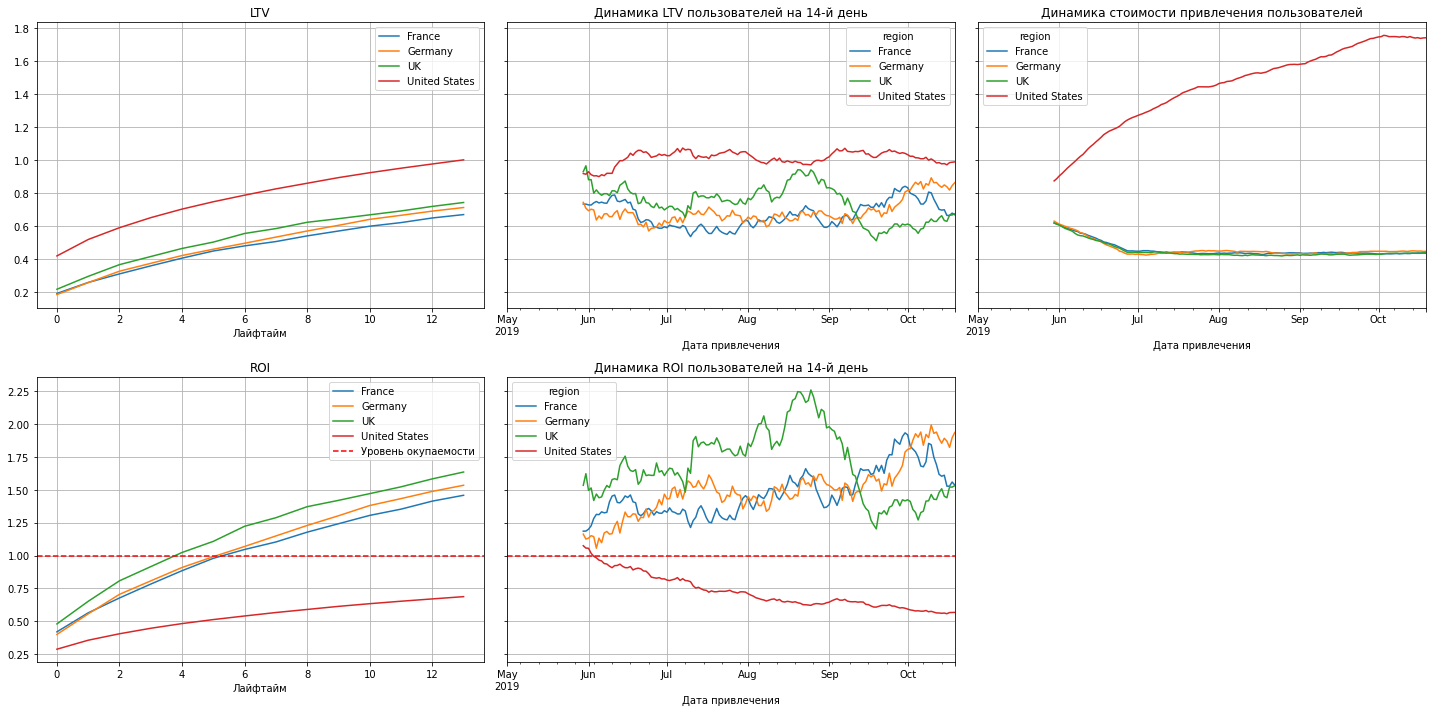

In [36]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 30)

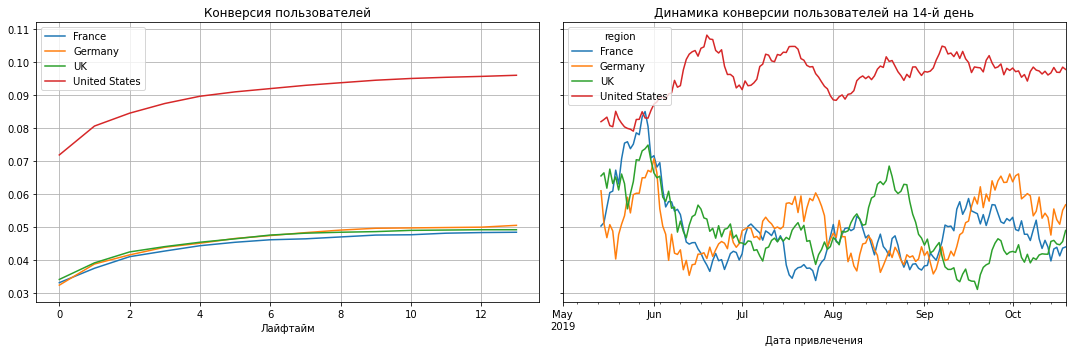

In [37]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, ['region'])

plot_conversion(conversion, conversion_history, horizon_days, 14)

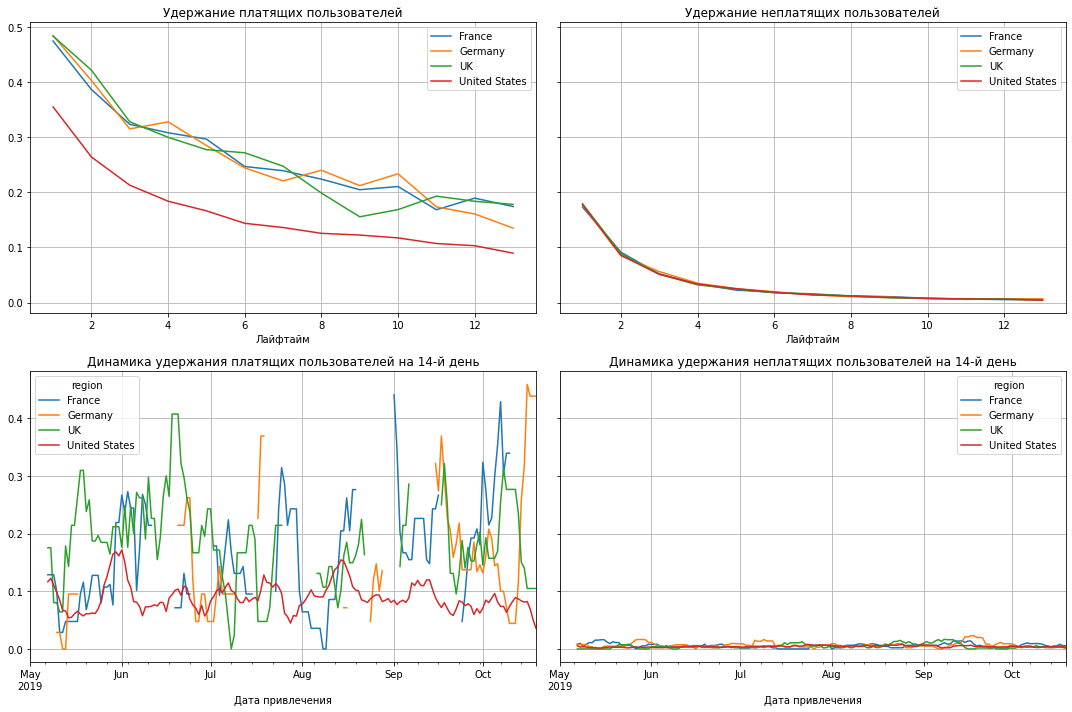

In [38]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['region'])


plot_retention(retention, retention_history, horizon_days, 7)

- LTV пользователей из США больше всех и составляет 1 дол.
- Значение LTV для пользователей из Великобратании уменьшилось с конца августа по середину сентября.
- Стоимость привлечения пользователей из США значительно выросла. А затраты на рекламу остальных источников уменьшилась с июня по июль. Скорее всего это связано с тем, что значительная часть рекламного бюджета была потрачена на привлечение пользователей из США.
- ROI пользователей из США составляет 70% на 14 день, что является неудовлетворительным показателем для бизнеса. ROI пользователей из Франции на 14 день - 145%, Великобритании - 165%, Германии - 155%.
- Динамика ROI показывает, что окупаемость пользователей из США снижается за последние полгода, что логично при стабильном LTV и ростущим САС. ROI для пользователей из Франции и Германии растет за последние полгода. Наблюдается резкое падение окупаемости пользователей из Британии с середины августа по середину октября.
- Конверсия пользователей из США больше остальных почти в 2 раза: 9,6% против 5%. 
- Конверсия пользователей из европейских стран значительно снизилась с начала июня. 
- Удержание платящих пользователей из США ниже остальных.
- Удержание платящих пользователей из Великобритании снизилась с середины июня по начало июля. 


<b>Промежуточный вывод и рекомендации:</b>
- Стоимость привлечения пользователей из США больше других в 3-4 раза, а LTV и конверсия выше (в 1,5 и 2 раза соответственно), следовательно стоит пересмортеть распределение рекламного бюджета в этом регионе.
- Удержание платящих пользователей из США на 14 день ниже остальные в 1,5-2 раза. Следует найти причину этого явления.
- LTV пользователей из Великобритании упал с 1 дол. до 0,7 дол. за последние 2 месяца. Следует выяснить причину.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

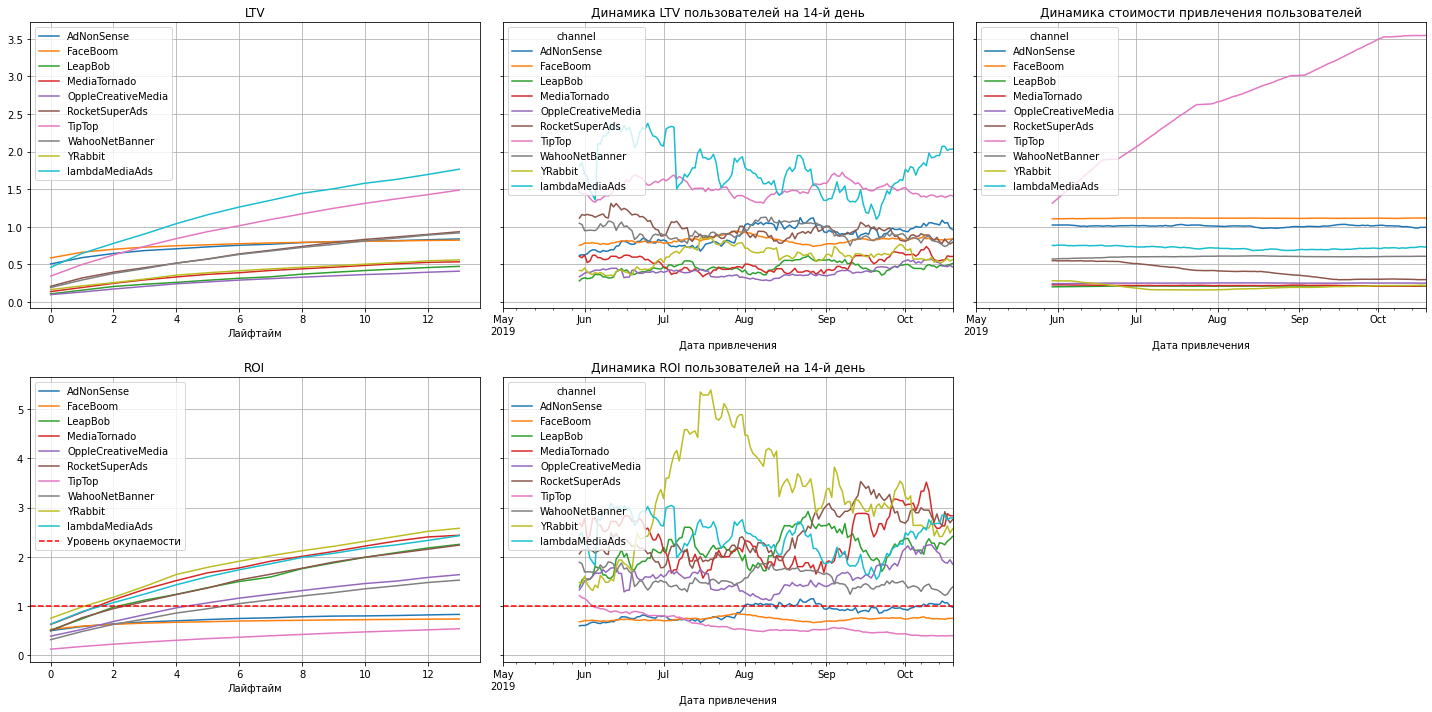

In [39]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 30)

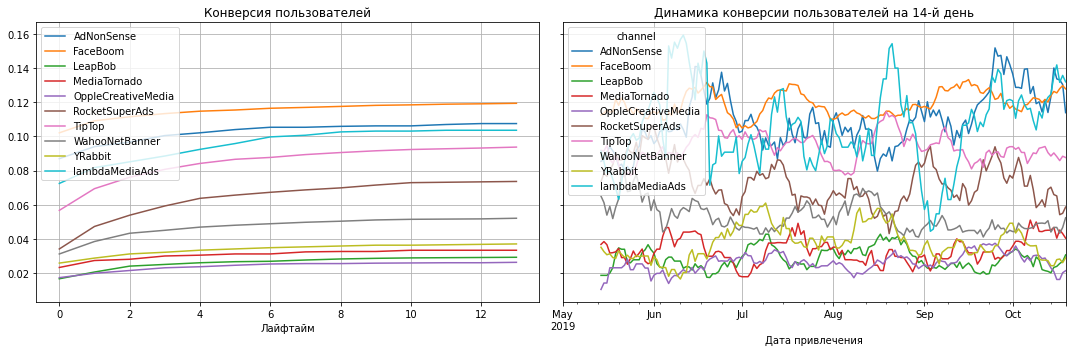

In [40]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, ['channel'])

plot_conversion(conversion, conversion_history, horizon_days, 14)

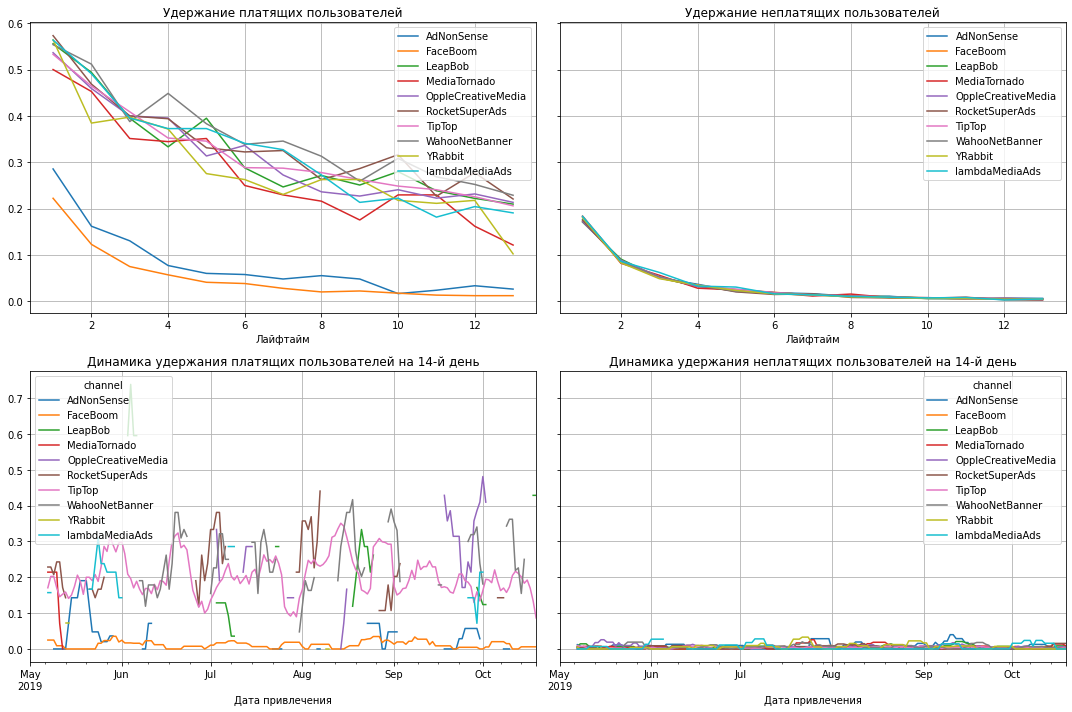

In [41]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['channel'])


plot_retention(retention, retention_history, horizon_days, 7)

- Наибольший LTV показывают пользователи привлеченные по каналу lambdaMediaAds и TipTop
- LTV пользователей привлеченных по каналу lambdaMediaAds падает с начала июня по середину сентября, а после показывает рост почти в 2 раза.
- По динамике САС наблюдается сильный рост стоимости привлечение пользователей по каналу TipTop и незначительное снижение по каналу RocketSuperAds.
- На 14 день ROI всех каналов привлечения больше 100% кроме трех: TipTop, FaceBoom и AdNonSense
- Показатель ROI значительно снизился для канала YRabbit с середины июля.
- Наибольшую конверсию показывают каналы FaceBoom, AdNonSense и lambdaMediaAds.
- Сильная просадка конверсии наблюдается для канала lambdaMediaAds. в начале сентября.
- Удержание пользователей по каналам FaceBoom и AdNonSense значительно ниже остальных.

<b>Промежуточный вывод и рекомендации:</b>
- LTV пользователя привлеченного по каналу lambdaMediaAds упал с 2,5 дол. до 1,2 дол. и вырос до 2 дол. Следует рассмотреть причину такого изменения.
- Рекламный бюджет распределяется только в пользу канала TipTop, который не окупается - 60% ROI. Стоит пересмотреть распределение рекламного бюджета от канала TipTop в пользу других каналов.
- Динамика ROI по каналу YRabbit уменьшился с 530% до 250%. Следует выяснить причину.

### Проведем дополнительный анализ окупаемости рекламы с разбивкой по рекламным каналам для пользователей из США. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [42]:
#иключим всех пользователей европейских пользователей
profiles_usa = profiles.query('region == "United States"')

#проверим, что все пользователи из европы исключены
profiles_usa.loc[profiles_usa['region'] != 'United States', 'region'].count()


0

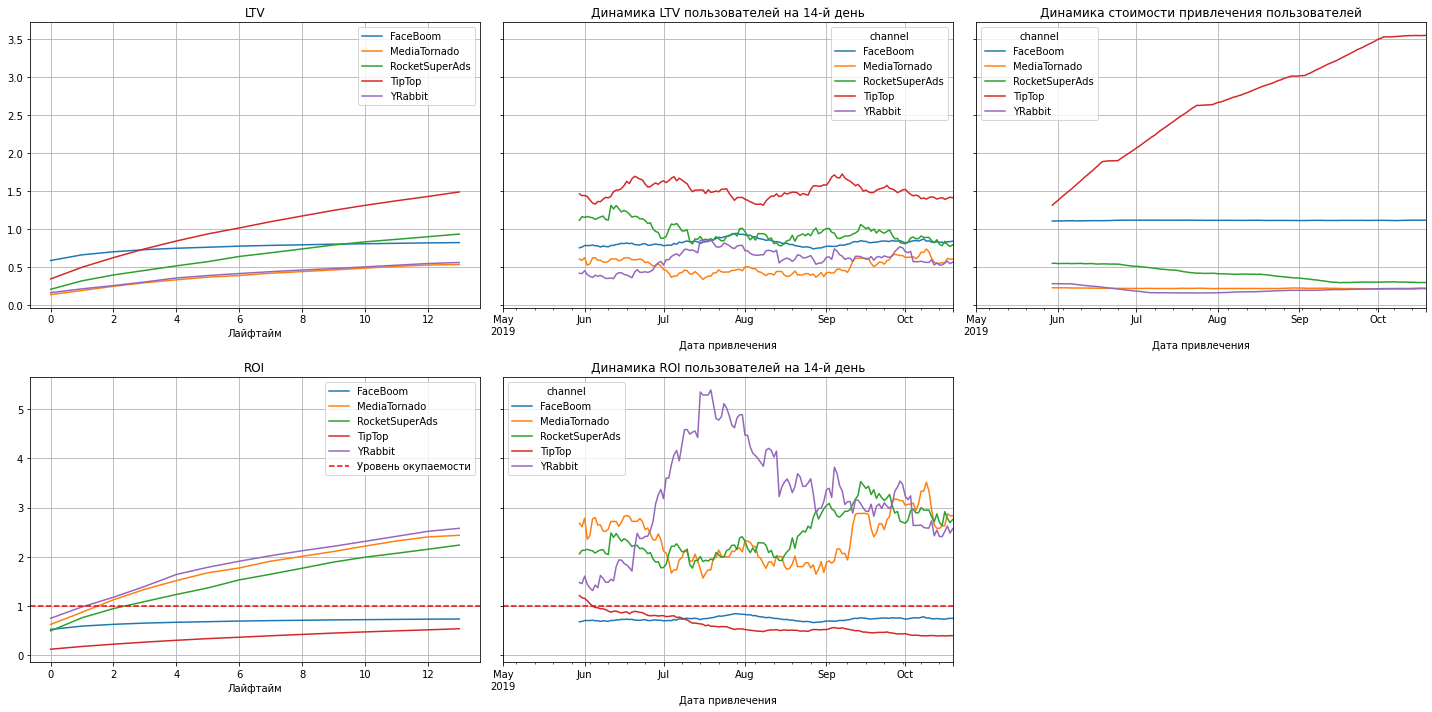

In [43]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, ['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 30)

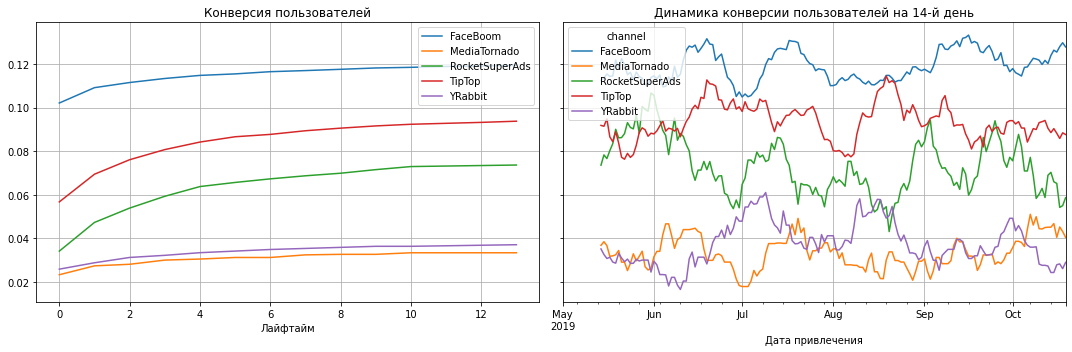

In [44]:
conversion_raw, conversion, conversion_history = get_conversion(profiles_usa, orders, observation_date, horizon_days, ['channel'])

plot_conversion(conversion, conversion_history, horizon_days, 14)

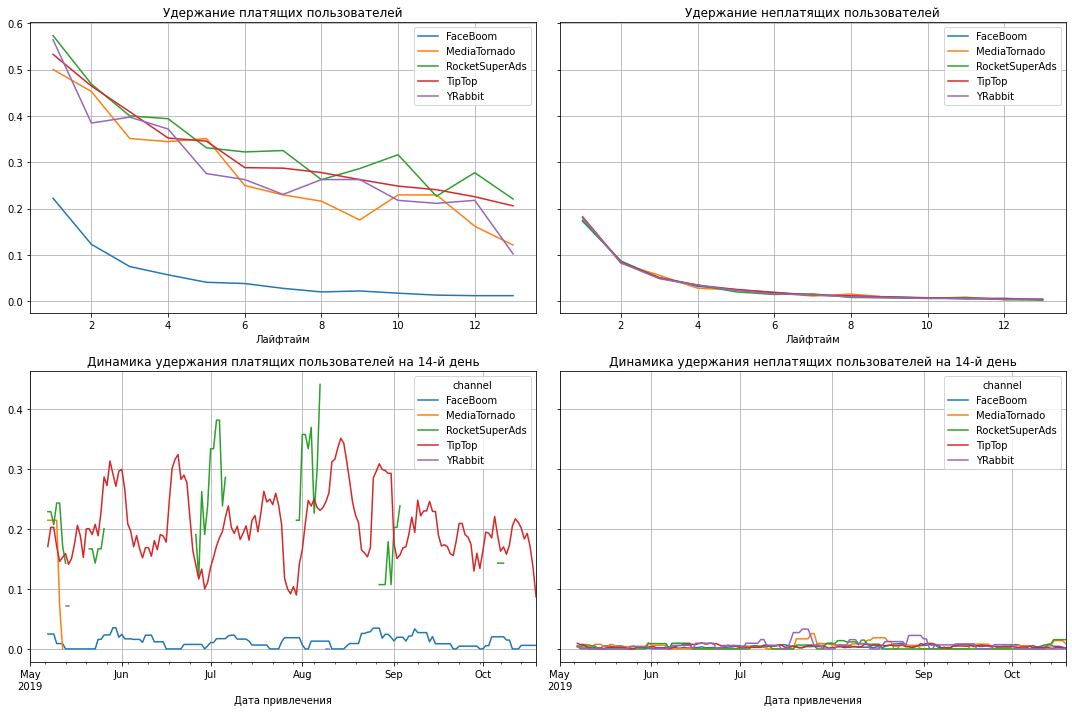

In [45]:
retention_raw, retention, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, ['channel'])


plot_retention(retention, retention_history, horizon_days, 7)

- Наибольший LTV показывают пользователи привлеченные по каналу TipTop
- LTV пользователей в течение полугода показывает боковой тренд.
- По динамике САС наблюдается сильный рост стоимости привлечение пользователей по каналу TipTop и незначительное снижение по каналу RocketSuperAds.
- ROI на 14 день по каналу RocketSuperAds сотавляет - 220%, MediaTornado - 250%, YRabbit- 250%, что явялется хорошим показателям для бизнеса
- Показатель ROI значительно снизился для канала YRabbit с середины июля. ROI каналов RocketSuperAds и MediaTornado увеличивается с августа.
- Конверсия пользователей выше всего по каналу FaceBoom и TipTop.
- Удержание пользователей по каналам FaceBoom значительно ниже остальных.

<b>Промежуточный вывод и рекомендации:</b>
- Рекламный бюджет распределяется только в пользу канала TipTop, который не окупается - 60% ROI. Стоит пересмотреть распределение рекламного бюджета от канала TipTop в пользу других каналов. Например:
1. Канал привлечения RocketSuperAds имеет окупаемость 220%, конверсию 6,5% и удержание не отличающееся от остальных каналов.
2. Канал привлечения YRabbit- имеет окупаемость 250%, конверсию 3,8% и удержание не отличающееся от остальных каналов.
3. Канал привлечения MediaTornado имеет окупаемость 250%, конверсию 3,2% и удержание не отличающееся от остальных каналов.
- Удержание платящих пользователей значительно ниже на FaceBoom. Следует найти причину.
- Динамика ROI по каналу YRabbit уменьшился с 530% до 250%. Следует выяснить причину.

### Проведем дополнительный анализ окупаемости рекламы с разбивкой по рекламным каналам для пользователей из Европы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [46]:
#иключим всех пользователей европейских пользователей
profiles_europa = profiles.query('region != "United States"')

#проверим, что все пользователи из европы исключены
profiles_europa.loc[profiles_europa['region'] == 'United States', 'region'].count()


0

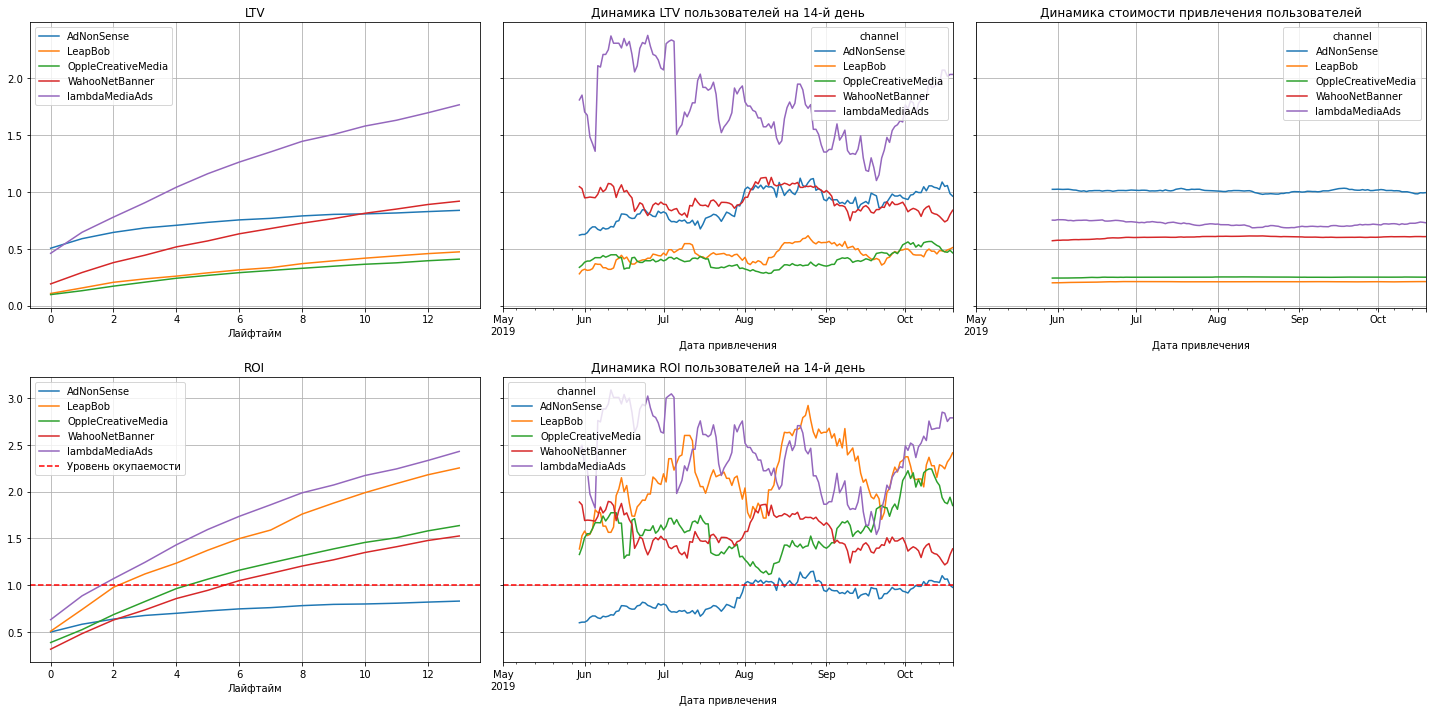

In [47]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_europa, orders, observation_date, horizon_days, ['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 30)

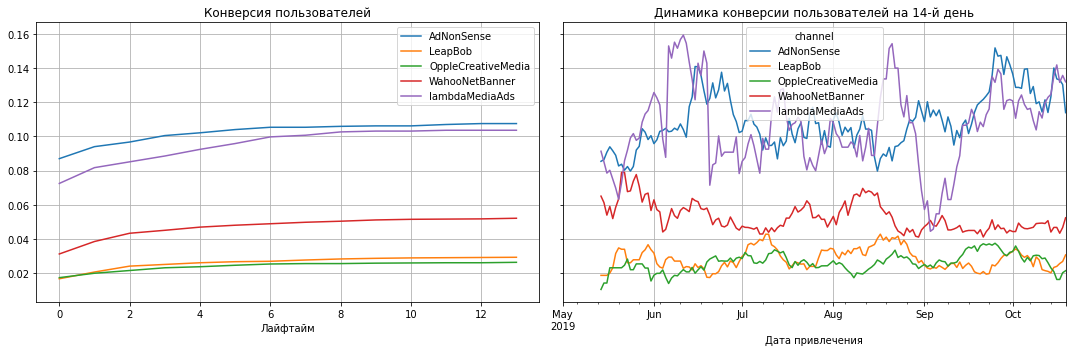

In [48]:
conversion_raw, conversion, conversion_history = get_conversion(profiles_europa, orders, observation_date, horizon_days, ['channel'])

plot_conversion(conversion, conversion_history, horizon_days, 14)

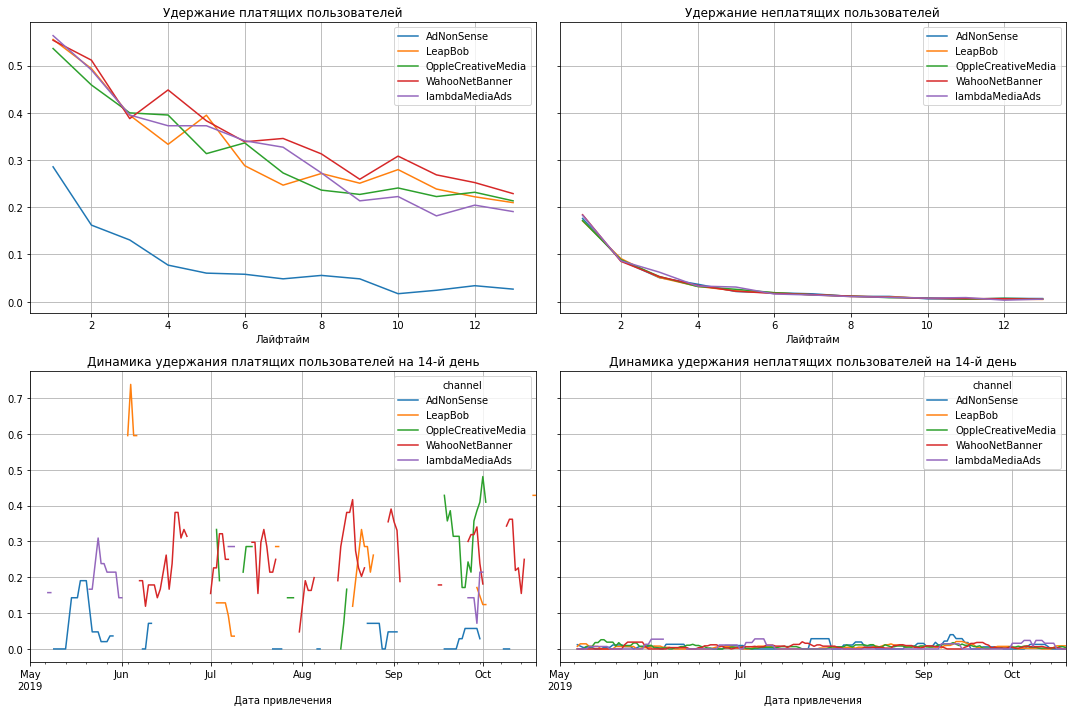

In [49]:
retention_raw, retention, retention_history = get_retention(
    profiles_europa, visits, observation_date, horizon_days, ['channel'])


plot_retention(retention, retention_history, horizon_days, 7)

- Наибольший LTV показывают пользователи привлеченные по каналу lambdaMediaAds
- LTV пользователей по каналу lambdaMediaAds снизилась с начала июля
- ROI на 14 день для канала lambdaMediaAds составляет 250%, LeapBob - 225%, что является хорошим показателем для бизнеса. ROI канала AdNonSense ниже 100%.
- Окупаемость по каналу lambdaMediaAds  значительно выроста с середины сентября, а окупаемость по каналу WahooNetBanner снижается с начала августа.
- Конверсия пользователей привлеченных по каналам AdNonSense и lambdaMediaAds  выше остальных и составляет 10%.
- Удержание платящих пользователей AdNonSense значительно ниже остальных.

<b>Промежуточный вывод и рекомендации:</b>
- LTV пользователей по каналу lambdaMediaAds снизилась с начала июля с 2,3 дол. до 1,2 дол. Следует выяснить причину.
- Следует распределить часть рекламного бюджета из Американского рынка в европейский в следующие каналы:
1. Канал привлечения lambdaMediaAds имеет окупаемость 250%, конверсию 10,2% и удержание не отличающееся от остальных каналов.
2. Канал привлечения LeapBob имеет окупаемость 225%, конверсию 3% и удержание не отличающееся от остальных каналов.
- Удержание платящих пользователей значительно ниже на AdNonSense. Следует найти причину.

## Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

<b>Общий вывод:</b>
- Окупаемость рекламных затрат - 80% и продолжает снижаться. LTV пользователя и конверсия находится на одном уровне в течение полугода 0,9 дол. и 8% соответственно. Удержание платящих пользователей снижается в течение полугода.
- Пользователи с устройствами Mac, iPhone и Android не окупаются (ROI 72%, 72% и 90% соответственно). Пользователи из США не окупаются (ROI 70%). Пользователи привлеченные по каналам TipTop, FaceBoom и AdNonSense не окупаются (50%, 80% и 70% соответственно).
- Удержание платящих пользователей из США, пользователей привлеченных по каналам FaceBoom и AdNonSense значительно отличаются от средних значений.
- Стоимость привлечения пользователей из США больше других (США - 1,75 дол. Остальные - 0,45 дол.). Это связано с том, что рекламный бюджет распределяется только в пользу канала TipTop.
- LTV пользователей с устройствами PC ниже остальных примерно на 10-15%. Окупаемость пользователей PC снизилась с 130% до 83%.
- LTV пользователей из Великобритании упал с 1 дол. до 0,7 дол. за последние 2 месяца.
- Динамика ROI по каналу YRabbit уменьшился с 530% до 250%.

<b>Основные рекомендации:</b>
- Стоит пересмотреть распределение рекламного бюджета от канала TipTop (LTV - 1.5 дол.,CAC - 3,5 дол., ROI - 50%, CR - 9%, RR - 20%) в пользу других каналов. Например:
Для Американского сегмента:
1. Канал привлечения RocketSuperAds: LTV - 0,95 дол., CAC - 0,3 дол., ROI - 220%, CR - 7,5%, RR - 22%
2. Канал привлечения YRabbit: LTV - 0,55 дол., CAC - 0,25 дол., ROI - 255%, CR - 3,8%, RR - 10%
3. Канал привлечения MediaTornado: LTV - 0,55 дол., CAC - 0,25 дол., ROI - 245%, CR - 3,2%, RR - 13%
Для Европейского сегмента:
1. Канал привлечения lambdaMediaAds: LTV - 1,75 дол., CAC - 0,75 дол., ROI - 245%, CR - 10,5%, RR - 19%
2. Канал привлечения LeapBob: LTV - 0,5 дол., CAC - 0,2 дол., ROI - 225%, CR - 3%, RR - 21%

<b>Дополнительные рекомендации:</b>
- Следует выяснить, почему LTV пользователей с устройствами PC ниже остальных примерно на 10-15%. А так же почему LTV пользователей с устройством PC упал с 0,9 дол в середине августа до 0,75 дол. в конце октября.
- Следует проверить, почему удержание платящих пользователей PC и Mac снизились на 17% и 10% в августе. Возможно был технический сбой.
- Следует выяснить причину, почему LTV пользователей из Великобритании упал с 1 дол. до 0,7 дол. за последние 2 месяца. А так же почему LTV пользователей по каналу lambdaMediaAds снизилась с начала июля с 2,3 дол. до 1,2 дол. 
- Следует найти причину, почему удержание платящих пользователей из США и платящих пользователей, привлеченныъ по каналам FaceBoom и AdNonSense значительно ниже нормы..
- Следует найти причину, почему динамика ROI по каналу YRabbit уменьшился с 530% до 250%.
- Следует перераспределить рекламный бюджет от пользователей с устройствами Mac и iPhone в пользу пользотвателей с устройствами PC, поскольку стоимость привлечения клиента ниже (0,9 дол. против 1,5 дол.), а окупаемость выше (105% против 70%). В случае, если ситуация сохранится после перераспределения рекламного бюджета по каналам привлечения